# Miniproject: Hopfield networks
### SCIPER: 308932, 322643

In [ ]:
#!pip install neurodynex3

In [ ]:
# start with importing the libraries we need

%matplotlib inline  
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import sympy, math
from sympy import *
import pandas as pd
import numpy as np
from neurodynex3.hopfield_network import pattern_tools, plot_tools, network
import neurodynex3.hopfield_network.pattern_tools as tools

## 1 Theory questions

## 2 Capacity

**Question 2.2**: Firstly, we use the alternative more efficient way to store the patterns and compare it with the neurodynex version

In [ ]:
class Hopfield_fast(network.HopfieldNetwork):
    def __init__(self, nr_neurons):
        super().__init__(nr_neurons)
    
    def store_patterns(self, pattern_list):
        # check if the input is a list or a numpy array
        if type(pattern_list) == list:
            pattern_list = np.array(pattern_list)
        pattern_list = pattern_list.reshape(pattern_list.shape[0],-1)
        pattern_size = pattern_list.shape[1]
        # fill in the following line for make the Hopfield_fast class to run
        self.weights = 1 / pattern_size  * np.einsum('mn,nk->mk', pattern_list.T, pattern_list) 
        np.fill_diagonal(self.weights, 0)

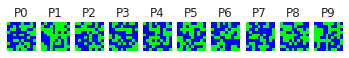

All the weights are the same:  True


In [ ]:
# Before you continue test that your weights are correct (compare with the neurodynex version)

## we define the number of patterns as 10 to do a test
nr_patterns = 10 
## pattern size should be the square root of number of neurons
pattern_size = 10

## create an instance of the class HopfieldNetwork by neurodynex version
hopfield_net_class = network.HopfieldNetwork(nr_neurons= pattern_size**2)
## create an instance of the fast HopfieldNetwork by we defined above.
hopfield_net_fast=Hopfield_fast(nr_neurons=pattern_size**2)

## instantiate a pattern factory
factory = pattern_tools.PatternFactory(pattern_size, pattern_size)

## Create the random patterns 
pattern_list = factory.create_random_pattern_list(nr_patterns, on_probability=0.5)
plot_tools.plot_pattern_list(pattern_list)

## let the hopfield network "learn" the patterns. 
hopfield_net_class.store_patterns(pattern_list)
hopfield_net_fast.store_patterns(pattern_list)

## test that your weights are correct (compare with the neurodynex version)
assert (hopfield_net_class.weights==hopfield_net_fast.weights).all()
print('All the weights are the same: ', (hopfield_net_class.weights==hopfield_net_fast.weights).all())

**Question 2.2**: Then, we can plot the probability for pattern p1 to be effectively stored decreases with the number of patterns P. 

In [ ]:
# initializa some parameters
## pattern size should be the square root of number of neurons
pattern_size = 10
## times for run the hopfield_net, generate many random Hopfield networks to estimate the probability.
simulation_times_run_script=10000
## numpy array about number of patterns
pattern_iter=np.arange(1,101,1)

In [ ]:
def calculate_probability(pattern_iter, pattern_size, simulation_times_run_script):
    probability_results=np.zeros(pattern_iter.shape)
    
    for pattern_num, x in zip(pattern_iter, range(pattern_iter.shape[0])):
        
        ##create an instance of the class HopfieldNetwork

        hopfield_net = Hopfield_fast(nr_neurons= pattern_size**2)
        ## instantiate a pattern factory
        factory = pattern_tools.PatternFactory(pattern_size, pattern_size)
        ## define a calculator
        idx=0
        
        for i in range(simulation_times_run_script):
            ## Create the random patterns 
            pattern_list=[]
            pattern_list.extend(factory.create_random_pattern_list(nr_patterns=pattern_num, on_probability=0.5))
            ## let the hopfield network "learn" the patterns. 
            hopfield_net.store_patterns(pattern_list)
            ## initialize with original pattern
            hopfield_net.set_state_from_pattern(pattern_list[0])
            ## from this initial state, let the network dynamics evolve.
            states = hopfield_net.run_with_monitoring(nr_steps=5)
            ## reshape the network to the same shape used to create the patterns.
            states_as_patterns = factory.reshape_patterns(states)
            
            # Calculate the overlap 
            overlaps_list = pattern_tools.compute_overlap_list(states_as_patterns[-1], pattern_list)
            if (np.argmax(overlaps_list) == 0):
                idx += 1
        
        probability_results[x]=idx/simulation_times_run_script
        print("Probability with", pattern_num, "is", probability_results[x])
    return probability_results        

In [ ]:
probability=calculate_probability(pattern_iter,pattern_size, simulation_times_run_script)

Probability with 1 is 1.0
Probability with 2 is 1.0
Probability with 3 is 1.0
Probability with 4 is 1.0
Probability with 5 is 1.0
Probability with 6 is 1.0
Probability with 7 is 1.0
Probability with 8 is 1.0
Probability with 9 is 1.0
Probability with 10 is 1.0
Probability with 11 is 0.9999
Probability with 12 is 1.0
Probability with 13 is 1.0
Probability with 14 is 0.9997
Probability with 15 is 0.9989
Probability with 16 is 0.999
Probability with 17 is 0.9987
Probability with 18 is 0.9983
Probability with 19 is 0.9969
Probability with 20 is 0.9962
Probability with 21 is 0.9924
Probability with 22 is 0.9931
Probability with 23 is 0.9905
Probability with 24 is 0.9868
Probability with 25 is 0.9842
Probability with 26 is 0.9827
Probability with 27 is 0.9794
Probability with 28 is 0.9751
Probability with 29 is 0.9672
Probability with 30 is 0.9645
Probability with 31 is 0.956
Probability with 32 is 0.9514
Probability with 33 is 0.9463
Probability with 34 is 0.9447
Probability with 35 is 0.93

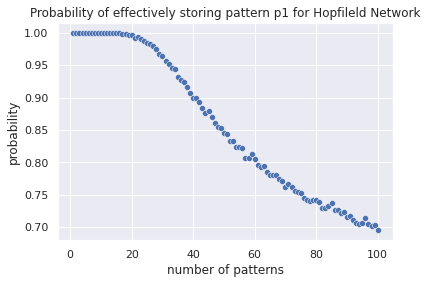

In [ ]:
prob_fast_plot = pd.DataFrame({"number of patterns":pattern_iter, "probability":probability})
sns.scatterplot(x = "number of patterns", y = "probability", data=prob_fast_plot)
sns.set(style='darkgrid',)
plt.title("Probability of effectively storing pattern p1 for Hopfileld Network")
plt.show()

* Question 2.3 : In this part, we first calculate the empirical capacity and then compare with theoretical capacity

In [ ]:
# the empirical capacity
C_em=sum(probability>=0.99)/100
print("the empirical capacity is:", C_em)

# the theoretical capacity
## firstly, we want to the erf value is above 1-2/N=0.98.
## according to the function we find that the erf(1.7)>=0.98
x = Symbol('x')
f=exp(-x**2)*2/(math.sqrt(math.pi))
inte_part=integrate(f, (x, 0, 1.7)).evalf()
print(inte_part)

## So we calculete the theoretical capacity:
C_th=math.floor((100/(1.7*1.7*2)+1))/100
print("the theoretical capacity is:", C_th)


the empirical capacity is: 0.23
0.983790458590774
the theoretical capacity is: 0.18


## 3 From binary neurons to saturated rectified linear neurons.

**Question 3.1:** the graph of function g for $\beta =1$

In [ ]:
# define the gain function with beta=1
def g(beta,h):
    out=np.minimum(1, np.maximum(-1, beta*h))
    return out

# assign the values of x-axis and y-axis
gx_values=np.linspace(-5, 5, 100)
gy_values=[g(1,i) for i in gx_values]
g_func_plot=pd.DataFrame({"h":gx_values, "g(h)":gy_values})

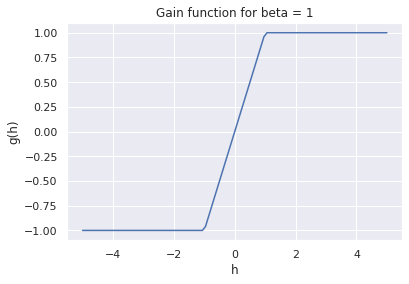

In [ ]:
# plot the g function
sns.lineplot(x = "h", y = "g(h)", data=g_func_plot)
plt.title('Gain function for beta = 1')
plt.show()

**Question 3.2:**  theory questions

**Question 3.3:**  In this question, we need to consider the influence of steepness $\beta$ on the capacity of network. So, we plot the capacity as a function of $\beta$ . 

In [ ]:
#firstly, we define the synchronize update function:
def beta_update_synchronize(beta):
    def network_update(state_s0, weights):
        h = np.sum(weights * state_s0, axis=1)
        g_h= np.minimum(1, np.maximum(-1, beta*h))
        state_s1=np.ones(g_h.shape)
        rand = np.random.uniform(0,1, g_h.shape)
        idx = g_h <= rand
        state_s1[idx] = -1
        return state_s1
    return network_update


## reference the homework solution: https://moodle.epfl.ch/pluginfile.php/2897801/mod_resource/content/1/solution_hopfield_network.ipynb
def beta_update_asynchronous(beta):
    def network_update(state_s0, weights):
        random_neuron_idx_list = np.random.permutation(len(state_s0))
        state_s1 = state_s0.copy()
        for i in range(len(random_neuron_idx_list)):
            rand_neuron_i = random_neuron_idx_list[i]
            h_i = np.dot(weights[:, rand_neuron_i], state_s1)
            prop_state_s1_on=np.minimum(1, np.maximum(-1, beta*h_i))
            state_s1[rand_neuron_i] = 1 if prop_state_s1_on > np.random.rand() else -1 
        return state_s1
    return network_update

def calculate_capacity(pattern_iter, pattern_size, simulation_times_run_script, betas, N, update_mode):
    capacity_results=np.zeros(betas.shape)
    for b, x in zip(betas, range(betas.shape[0])):
        probability_results=np.zeros(pattern_iter.shape)
        for pattern_num, y in zip(pattern_iter, range(pattern_iter.shape[0])):
            # create an instance of the fast HopfieldNetwork
            hopfield_net = Hopfield_fast(nr_neurons= pattern_size**2)
            # set the update function
            if (update_mode=="synchronize"):
                hopfield_net.set_dynamics_to_user_function(beta_update_synchronize(beta=b))
            elif (update_mode=="asynchronous"):
                hopfield_net.set_dynamics_to_user_function(beta_update_asynchronous(beta=b))
            #instantiate a pattern factory
            factory = pattern_tools.PatternFactory(pattern_size, pattern_size)
            ## define a calculator
            idx=0
                   
            for i in range(simulation_times_run_script):
                ## Create the random patterns 
                pattern_list=[]
                pattern_list.extend(factory.create_random_pattern_list(nr_patterns=pattern_num, on_probability=0.5))
                ## let the hopfield network "learn" the patterns. 
                hopfield_net.store_patterns(pattern_list)
                ## initialize with original pattern
                hopfield_net.set_state_from_pattern(pattern_list[0])
                ## from this initial state, let the network dynamics evolve. 
                states = hopfield_net.run_with_monitoring(nr_steps=5)
                ## reshape the network to the same shape used to create the patterns.
                states_as_patterns = factory.reshape_patterns(states)
                   
                overlap_list = pattern_tools.compute_overlap_list(states_as_patterns[-1], pattern_list)
                if (np.argmax(overlap_list) == 0): 
                    idx += 1
                   
            probability_results[y]=idx/simulation_times_run_script
        capacity_results[x]=sum(probability_results>=0.99)/N
        print('Beta='+str(b)+', Capacity='+str(capacity_results[x]))
    return capacity_results    


In [ ]:
# Next, we define the initialize the beta value and patterns number list value
betas=np.arange(0,33,3)
betas[0]=1
print(betas)
pattern_iter=np.arange(1,100,1)

#betas=np.arange(1,31,1)
#pattern_iter=np.array([1,10,20,30,40,50,60,70,80,90,100])
# define the other parameters:
simulation_times_run_script=2000
pattern_size=10
N=100


[ 1  3  6  9 12 15 18 21 24 27 30]


In [ ]:
capacity_results=calculate_capacity(pattern_iter, pattern_size, simulation_times_run_script, betas, N, "synchronize")

Beta=1, Capacity=0.01
Beta=3, Capacity=0.19
Beta=6, Capacity=0.23
Beta=9, Capacity=0.23
Beta=12, Capacity=0.24
Beta=15, Capacity=0.22
Beta=18, Capacity=0.23
Beta=21, Capacity=0.23
Beta=24, Capacity=0.24
Beta=27, Capacity=0.23
Beta=30, Capacity=0.23


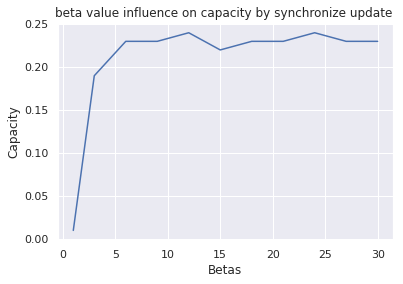

In [ ]:
func_beta_plot=pd.DataFrame({"Betas":betas, "Capacity":capacity_results})
sns.lineplot(x = "Betas", y = "Capacity", data=func_beta_plot)
plt.title('beta value influence on capacity by synchronize update ')
plt.show()


In [ ]:
capacity_results_asynchronous=calculate_capacity(pattern_iter, pattern_size, simulation_times_run_script, betas, N, "asynchronous")

Beta=1, Capacity=0.01
Beta=3, Capacity=0.12
Beta=6, Capacity=0.15
Beta=9, Capacity=0.15
Beta=12, Capacity=0.16
Beta=15, Capacity=0.16
Beta=18, Capacity=0.16
Beta=21, Capacity=0.15
Beta=24, Capacity=0.16
Beta=27, Capacity=0.16
Beta=30, Capacity=0.16


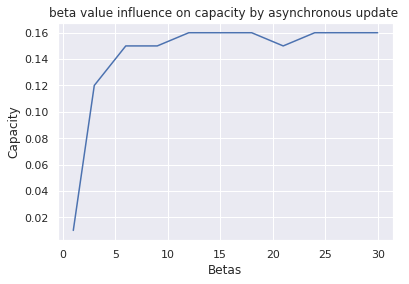

In [ ]:
func_beta_plot_as=pd.DataFrame({"Betas":betas, "Capacity":capacity_results_asynchronous})
sns.lineplot(x = "Betas", y = "Capacity", data=func_beta_plot_as)
plt.title('beta value influence on capacity by asynchronous update ')
plt.show()

**Question 3.4 :** We plot the network dynamics with a small beta value 0.5 for the first random pattern and observe the evolution.

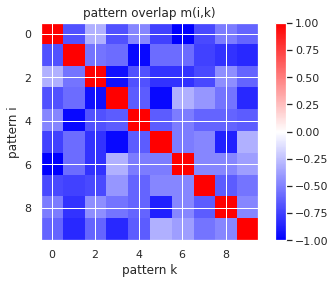

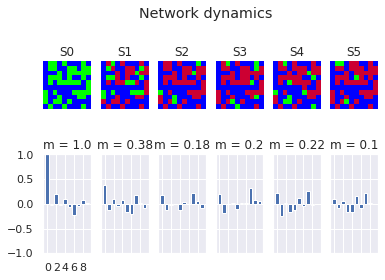

In [ ]:
beta_ex = 0.5
pattern_size = 10
# create an instance of the fast HopfieldNetwork
hopfield_net = Hopfield_fast(nr_neurons= pattern_size**2)
# set the update function
hopfield_net.set_dynamics_to_user_function(beta_update_asynchronous(beta=beta_ex))
factory = pattern_tools.PatternFactory(pattern_size, pattern_size)
pattern_list=factory.create_random_pattern_list(nr_patterns=10, on_probability=0.5)
overlap_matrix = pattern_tools.compute_overlap_matrix(pattern_list)
plot_tools.plot_overlap_matrix(overlap_matrix)
hopfield_net.store_patterns(pattern_list)
hopfield_net.set_state_from_pattern(pattern_list[0])
states = hopfield_net.run_with_monitoring(nr_steps=5)
states_as_patterns = factory.reshape_patterns(states)
plot_tools.plot_state_sequence_and_overlap(states_as_patterns, pattern_list, reference_idx=0, suptitle="Network dynamics") 

**Question 3.5:** theory questions

## 4 Correlated patterns
### Question 1
In this part, we consider the effect of correlations among patterns on the capacity.

In [ ]:
#Firstly, we define the corresponding parameters:
## the pattern numbers
pattern_iter=np.arange(1,101,1)
## the k values
ks=np.arange(0,100,10)
## N=100 neurons
N = 100
## pattern size should be the square root of number of neurons
pattern_size = 10
simulation_times_run_script=2000

In [ ]:
def correlated_patterns(pattern_list, k, pattern_size):
    corr_pattern_list=[]
    #all the other patterns should share the first k elements with the first patten
    corr_pattern=pattern_list[0]
    row_idx=k//pattern_size
    column_idx=k%pattern_size
    for pattern in pattern_list:
        pattern[0:row_idx]=corr_pattern[0:row_idx]
        pattern[row_idx,0:column_idx]=pattern[row_idx,0:column_idx]
        corr_pattern_list.append(pattern)
    return corr_pattern_list

In [ ]:
# then we define the function
def calculate_capacity_for_correlation(pattern_iter, pattern_size, simulation_times_run_script, ks, N):
    capacity_results=np.zeros(ks.shape)
    for k, x in zip(ks, range(ks.shape[0])):
        probability_results=np.zeros(pattern_iter.shape)
        for pattern_num, y in zip(pattern_iter, range(pattern_iter.shape[0])):
            # create an instance of the fast HopfieldNetwork
            hopfield_net = Hopfield_fast(nr_neurons= pattern_size**2)
            #instantiate a pattern factory
            factory = pattern_tools.PatternFactory(pattern_size, pattern_size)
            ## define a calculator
            idx=0
                   
            for i in range(simulation_times_run_script):
                ## Create the random patterns 
                pattern_list=[]
                pattern_list.extend(factory.create_random_pattern_list(nr_patterns=pattern_num, on_probability=0.5))
                ## create the new correlated patterns
                corr_pattern_list=correlated_patterns(pattern_list, k, pattern_size)
                ## let the hopfield network "learn" the patterns. 
                hopfield_net.store_patterns(corr_pattern_list)
                ## initialize with original pattern
                hopfield_net.set_state_from_pattern(corr_pattern_list[0])
                ## from this initial state, let the network dynamics evolve. Because we fix the time steps as 5, so the number there is 5-4=1
                states = hopfield_net.run_with_monitoring(nr_steps=5)
                ## reshape the network to the same shape used to create the patterns.
                states_as_patterns = factory.reshape_patterns(states)
                   
                overlap_list = pattern_tools.compute_overlap_list(states_as_patterns[-1], corr_pattern_list)
                if (np.argmax(overlap_list)==0): 
                    idx += 1
                   
            probability_results[y]=idx/simulation_times_run_script
        capacity_results[x]=sum(probability_results>=0.99)/N
        print('ratio of k to N='+str(k/N)+', Capacity='+str(capacity_results[x]))
    return capacity_results 

In [ ]:
capacity_results_correlation=calculate_capacity_for_correlation(pattern_iter, pattern_size, simulation_times_run_script, ks, N)

ratio of k to N=0.0, Capacity=0.23
ratio of k to N=0.1, Capacity=0.09
ratio of k to N=0.2, Capacity=0.04
ratio of k to N=0.3, Capacity=0.04
ratio of k to N=0.4, Capacity=0.02
ratio of k to N=0.5, Capacity=0.02
ratio of k to N=0.6, Capacity=0.02
ratio of k to N=0.7, Capacity=0.02
ratio of k to N=0.8, Capacity=0.02
ratio of k to N=0.9, Capacity=0.02


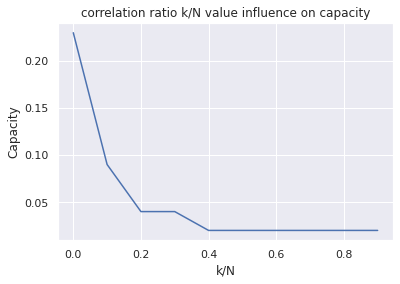

In [ ]:
func_corr_plot=pd.DataFrame({"k/N":ks/N, "Capacity":capacity_results_correlation})
sns.lineplot(x = "k/N", y = "Capacity", data=func_corr_plot)
plt.title('correlation ratio k/N value influence on capacity')
plt.show()